# Sentiment Analysis

## Imports, constants and setup

In [1]:
import time
import tracemalloc
import warnings
from collections import Counter

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from wordcloud import WordCloud

from app.constants import CACHE_DIR, DATA_DIR
from app.data import load_data, tokenize
from app.model import _get_vectorizer

In [2]:
tqdm.pandas()

In [3]:
SEED = 42
CACHE = joblib.Memory(CACHE_DIR, verbose=0)

## Data loading

In [4]:
# Load data and convert to pandas DataFrame
text_data, label_data = load_data("test")
dataset = pd.DataFrame({"text": text_data, "sentiment": label_data})
dataset.head()

,text,sentiment
0,The impact of educational reforms remains unce...,1
1,Critics argue that recent improvements in the ...,0
2,Innovative teaching methods have led to unexpe...,1
3,"Despite budget constraints, the school has man...",1
4,The true effectiveness of online learning plat...,0


In [5]:
# Tokenize text data
tokens = tokenize(dataset["text"].tolist(), batch_size=1024, n_jobs=2, show_progress=True)
dataset["tokens"] = tokens.apply(" ".join)
dataset.head()

Lemmatization: 100%|██████████| 209/209 [00:00<00:00, 395.78doc/s]


,text,sentiment,tokens
0,The impact of educational reforms remains unce...,1,impact educational reform remain uncertain des...
1,Critics argue that recent improvements in the ...,0,critic argue recent improvement school system ...
2,Innovative teaching methods have led to unexpe...,1,innovative teaching method lead unexpected cha...
3,"Despite budget constraints, the school has man...",1,despite budget constraint school manage mainta...
4,The true effectiveness of online learning plat...,0,true effectiveness online learning platform ma...


## Data exploration

### Sentiment distribution

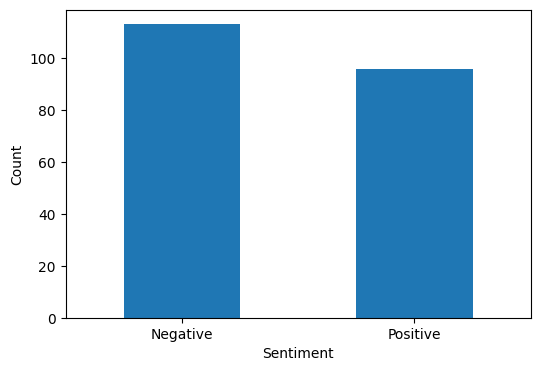

In [6]:
_, ax = plt.subplots(figsize=(6, 4))

dataset["sentiment"].value_counts().plot(kind="bar", ax=ax)
ax.set_xticklabels(["Negative", "Positive"], rotation=0)
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")

plt.show()

### Word cloud (before tokenization)

  0%|          | 0/209 [00:00<?, ?it/s]

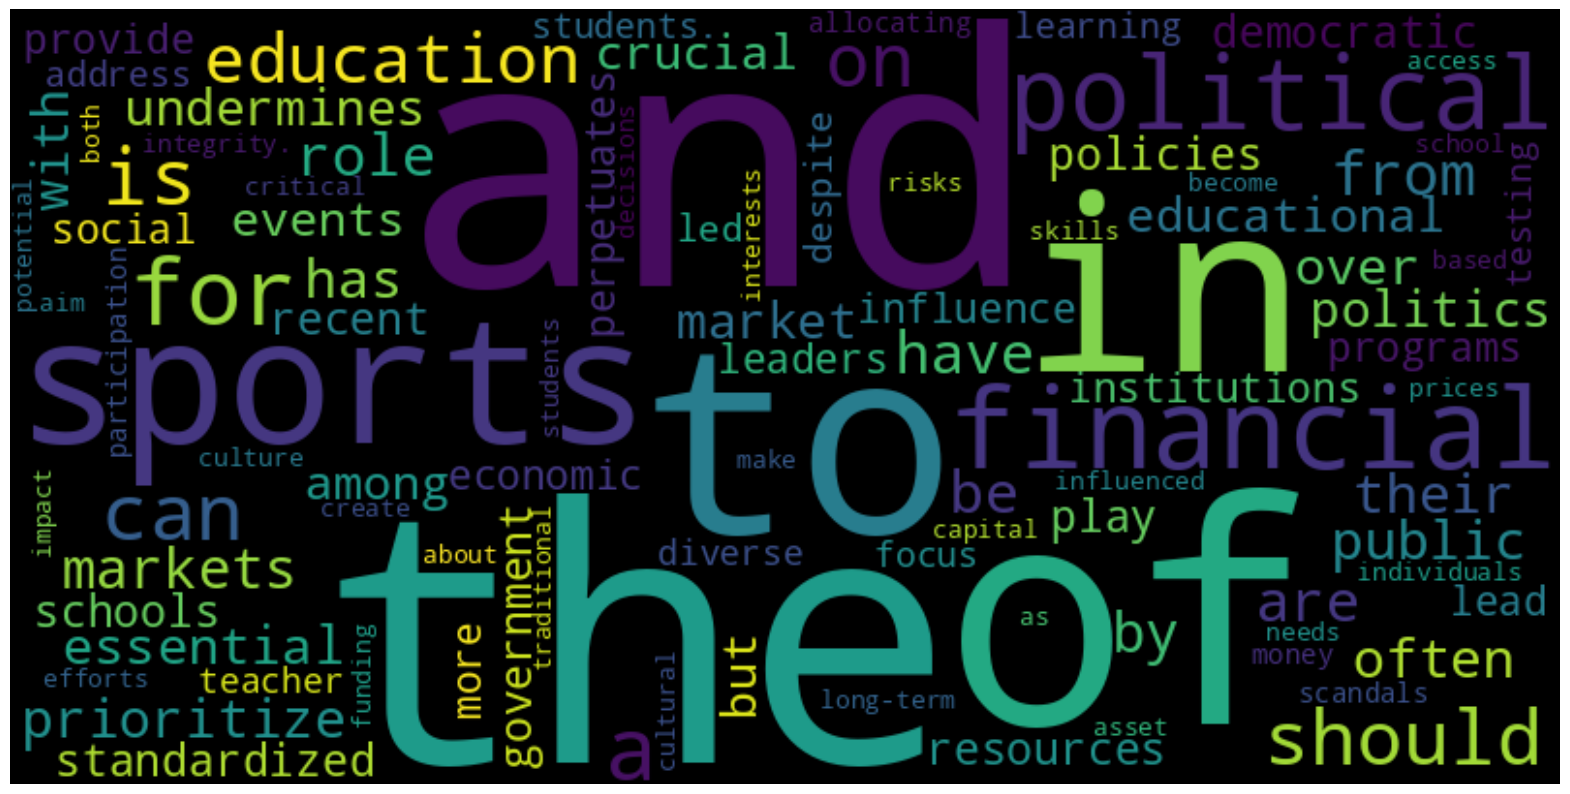

In [7]:
# Gather all the unique words in the dataset
word_freq = Counter()
dataset["text"].str.lower().str.split().progress_apply(word_freq.update)

# Now get the most common words
common_words = word_freq.most_common(100)

# Create a word cloud of the most common words
wrd_cloud = WordCloud(width=800, height=400, random_state=SEED).generate_from_frequencies(dict(common_words))

# Display the word cloud
plt.figure(figsize=(20, 20))
plt.imshow(wrd_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Word cloud (after tokenization)

  0%|          | 0/209 [00:00<?, ?it/s]

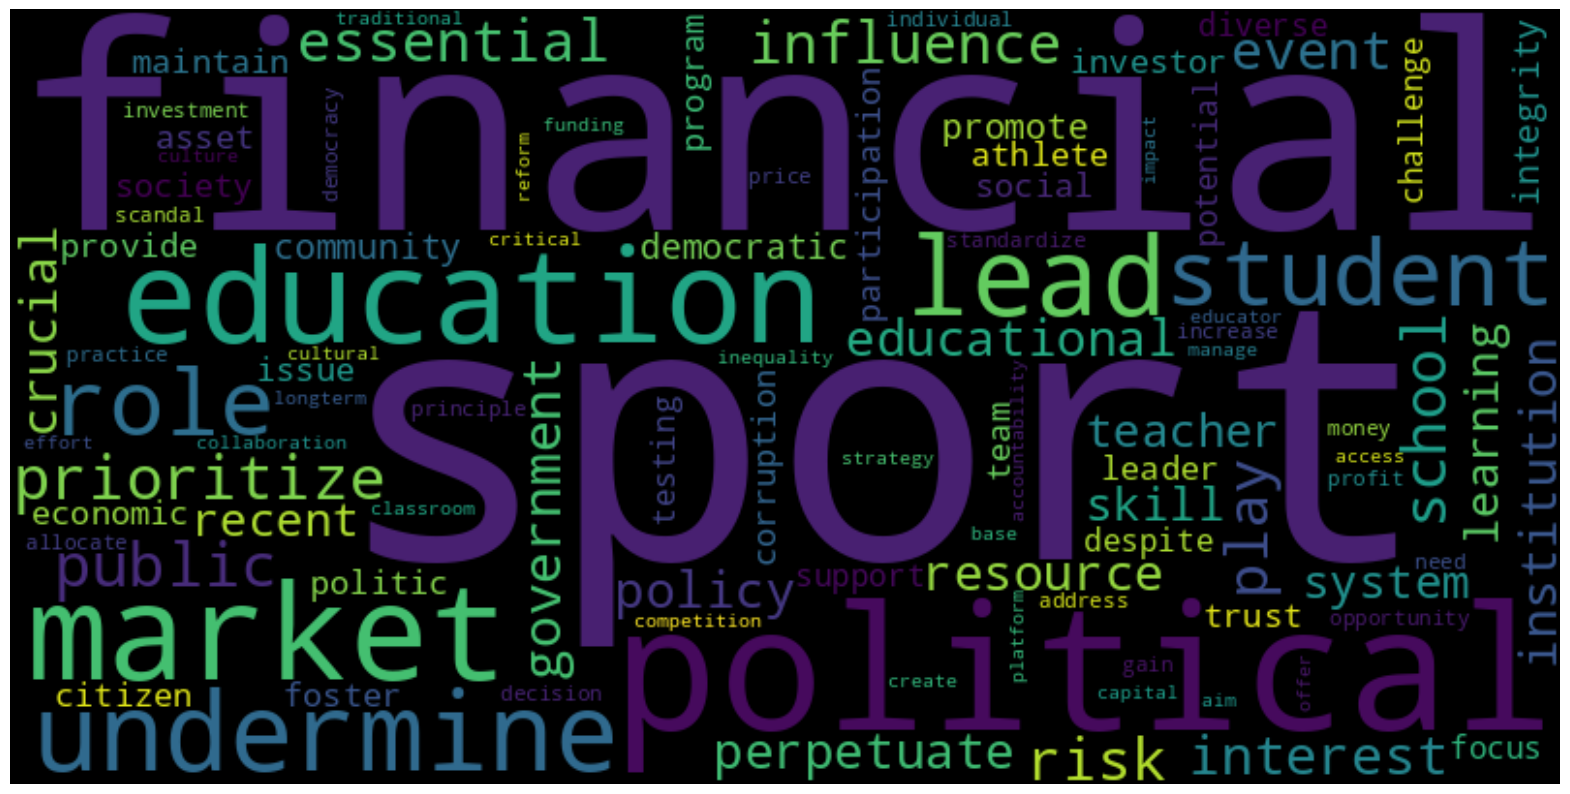

In [8]:
# Gather all the unique tokens in the dataset
token_freq = Counter()
dataset["tokens"].str.split().progress_apply(token_freq.update)

# Now get the most common tokens
common_tokens = token_freq.most_common(100)

# Create a word cloud of the most common tokens
tkn_cloud = WordCloud(width=800, height=400, random_state=SEED).generate_from_frequencies(dict(common_tokens))

# Display the word cloud
plt.figure(figsize=(20, 20))
plt.imshow(tkn_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Token association

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

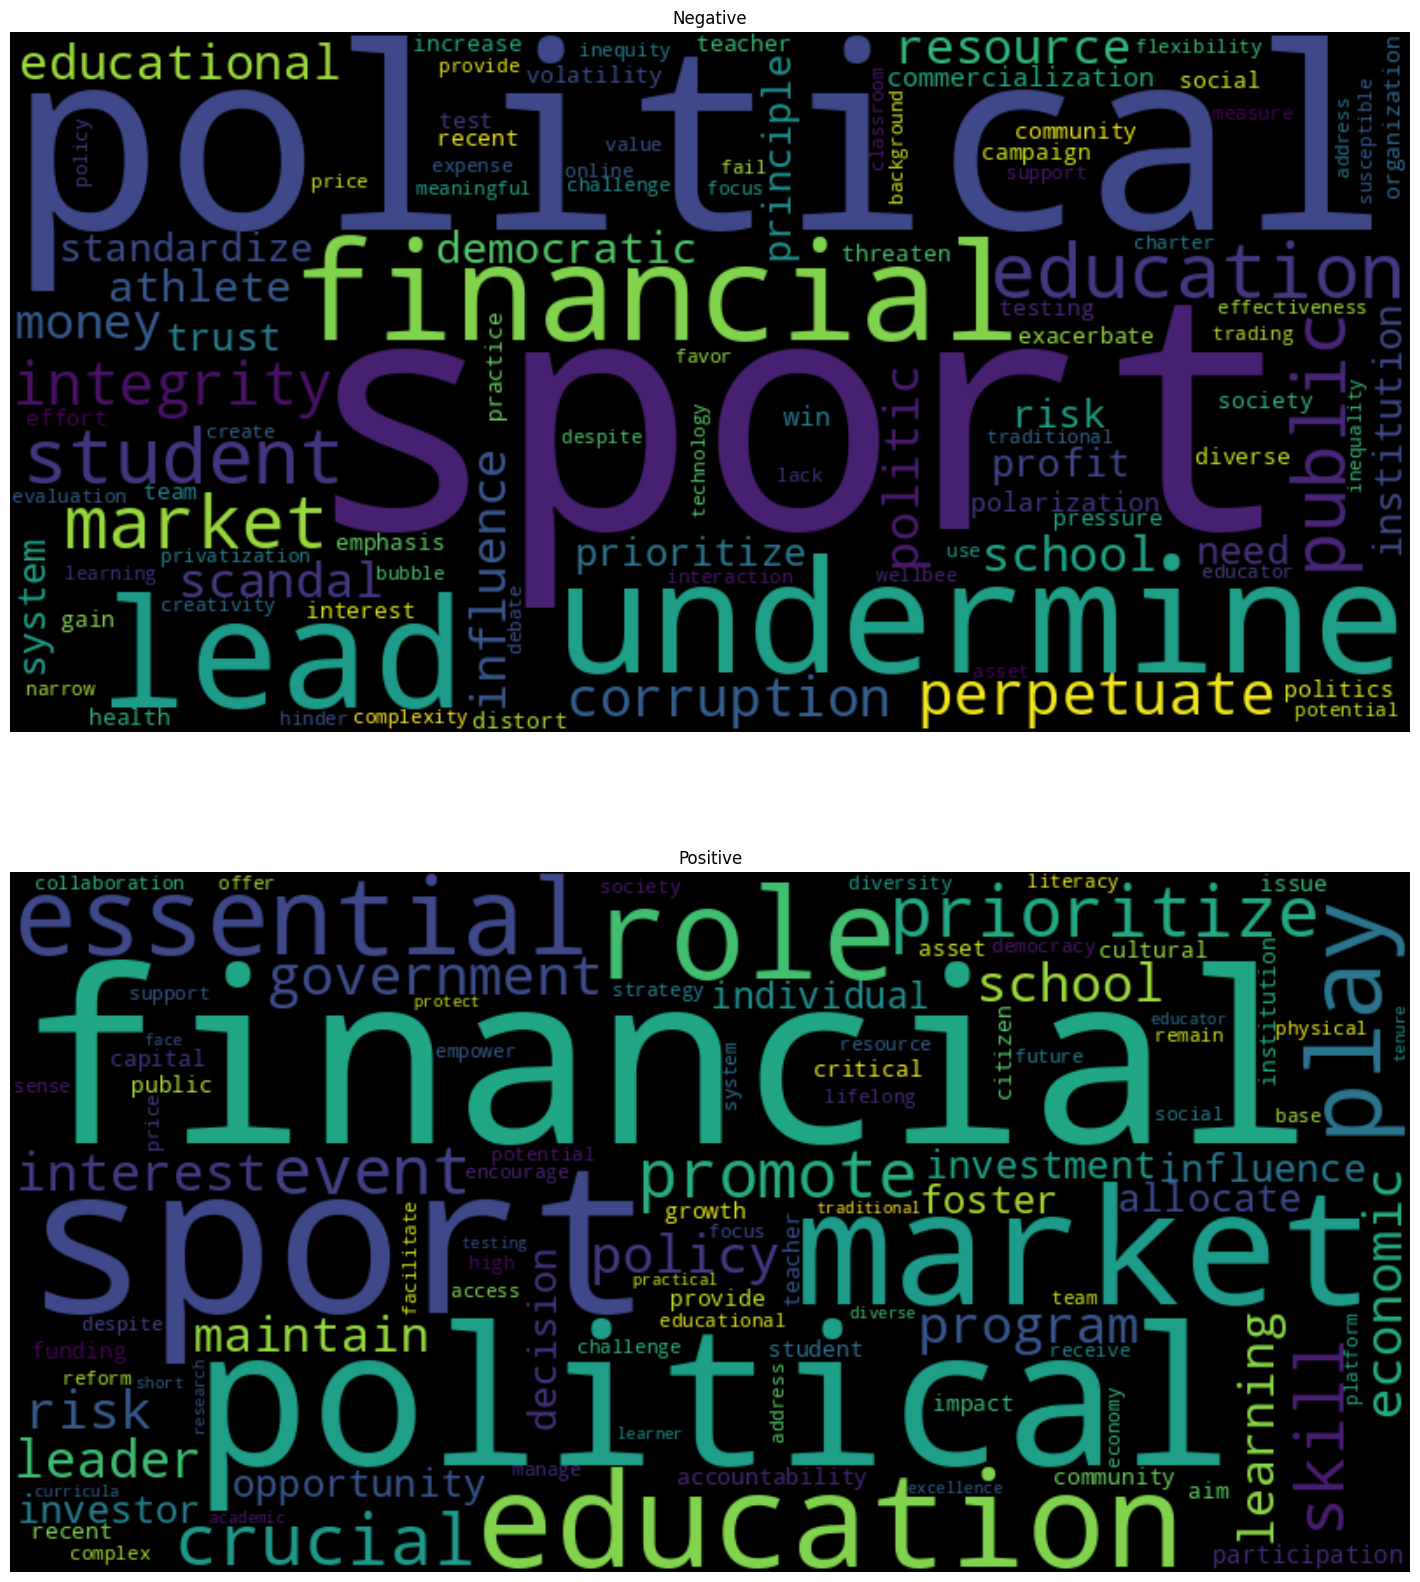

In [9]:
_, ax = plt.subplots(2, 1, figsize=(20, 20))

for i, sentiment in enumerate(["Negative", "Positive"]):
    freq = Counter()
    dataset[dataset["sentiment"] == i]["tokens"].str.split().progress_apply(freq.update)
    most_common = freq.most_common(100)

    cloud = WordCloud(width=800, height=400, random_state=SEED).generate_from_frequencies(dict(most_common))
    ax[i].imshow(cloud, interpolation="bilinear")
    ax[i].axis("off")
    ax[i].set_title(sentiment)

plt.show()

### Token frequency

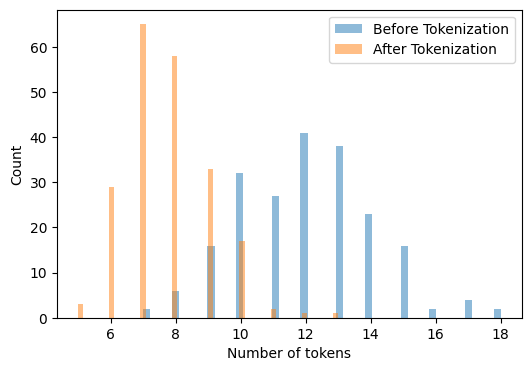

In [10]:
_, ax = plt.subplots(figsize=(6, 4))

dataset["text"].str.split().str.len().plot(kind="hist", bins=50, ax=ax, alpha=0.5, label="Before Tokenization")
dataset["tokens"].str.split().str.len().plot(kind="hist", bins=50, ax=ax, alpha=0.5, label="After Tokenization")

ax.set_xlabel("Number of tokens")
ax.set_ylabel("Count")
ax.legend()
plt.show()

### Vocabulary size

In [11]:
print(f"Vocabulary size before tokenization: {len(word_freq)}")
print(f"Vocabulary size after tokenization: {len(token_freq)}")

Vocabulary size before tokenization: 947
Vocabulary size after tokenization: 689


## Vectorization

The `count` vectorizer is a simple vectorizer that counts the number of times a token appears in a document. The `tfidf` does the same as `count` but also normalizes the counts by the inverse document frequency. The `hashing` vectorizer is a memory efficient vectorizer that uses a hash function to map tokens to features. The `hashing` vectorizer does not store the vocabulary in memory, which makes it possible to vectorize large datasets.

In [12]:
# Define vectorizers
vectorizers = {
    "hashing": _get_vectorizer("hashing", n_features=2**20),
    "count": _get_vectorizer("count", 20_000),
    "tfidf": _get_vectorizer("tfidf", 20_000),
}

In [13]:
# Fit and vectorize the tokens
token_list = dataset["tokens"].str.split().tolist()
X = {name: vectorizer.fit_transform(token_list) for name, vectorizer in vectorizers.items()}

# Display the shape of the vectorized data
for name, data in X.items():
    print(f"{name}: {data.shape}")

hashing: (209, 1048576)
count: (209, 82)
tfidf: (209, 82)


In [14]:
# Print the first 10 features of count and tfidf vectorizers
features = vectorizers["count"].get_feature_names_out()[:10]
print(", ".join(features))

address, allocate, asset, athlete, challenge, citizen, community, corruption, crucial, crucial role


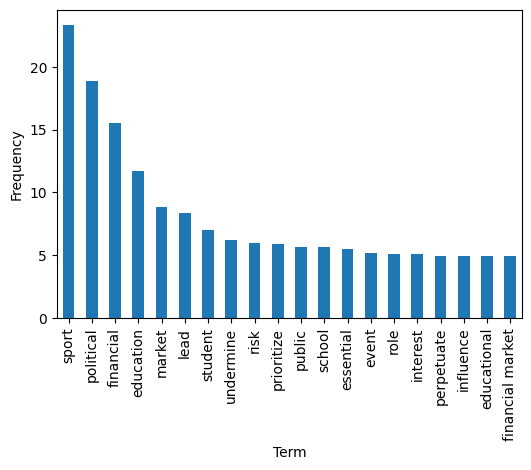

In [15]:
# Plot top 20 features of tfidf vectorizer
features = vectorizers["tfidf"].get_feature_names_out()
terms = pd.DataFrame(X["tfidf"].toarray(), columns=features)

_, ax = plt.subplots(figsize=(6, 4))
terms.sum().sort_values(ascending=False).head(20).plot(kind="bar", ax=ax)
ax.set_xlabel("Term")
ax.set_ylabel("Frequency")
plt.show()

## Classification

In [16]:
# Define classifiers
classifiers = [
    (LogisticRegression(max_iter=1000, random_state=SEED), {"C": np.logspace(-3, 3, 20)}),
    (SVC(random_state=SEED), {"C": np.logspace(-3, 3, 20), "gamma": np.logspace(-3, 3, 20)}),
    (KNeighborsClassifier(), {"n_neighbors": np.arange(1, 12)}),
    (DecisionTreeClassifier(random_state=SEED), {"max_depth": np.arange(1, 12)}),
    (RandomForestClassifier(random_state=SEED), {"n_estimators": np.arange(10, 500, 50)}),
    (AdaBoostClassifier(algorithm="SAMME", random_state=SEED), {"n_estimators": np.arange(10, 500, 50)}),
    (GradientBoostingClassifier(random_state=SEED), {"n_estimators": np.arange(100, 500, 25)}),
    (
        VotingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=1000, random_state=SEED)),
                ("svc", SVC(random_state=SEED)),
                ("rf", RandomForestClassifier(random_state=SEED)),
            ],
        ),
        {
            "lr__C": np.logspace(-3, 3, 20),
            "svc__C": np.logspace(-3, 3, 20),
            "svc__gamma": np.logspace(-3, 3, 20),
            "rf__n_estimators": np.arange(10, 500, 50),
        },
    ),
    (
        MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000, random_state=SEED),
        {"learning_rate_init": np.logspace(-3, 0, 20), "batch_size": [32, 64, 128]},
    ),
]

In [19]:
# Split the data into training and testing sets (using TF-IDF vectorizer)
X_train, X_test, y_train, y_test = train_test_split(X["tfidf"], dataset["sentiment"], test_size=0.2, random_state=SEED)

In [20]:
# Define the cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [21]:
# Start memory profiling
tracemalloc.start()

# Perform random search to find the best hyperparameters
estimators = []  # (estimator, time, memory)
for clf, params in tqdm(classifiers, unit="clf"):
    search = RandomizedSearchCV(
        clf,
        params,
        cv=kfold,
        n_iter=10,
        scoring="accuracy",
        random_state=SEED,
        verbose=0,
    )

    start_time = time.time()
    before = tracemalloc.take_snapshot()

    with warnings.catch_warnings():
        warnings.filterwarnings("once", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=UserWarning, message="Persisting input arguments took")
        search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time
    after = tracemalloc.take_snapshot()
    mem_usage = sum(stat.size for stat in after.compare_to(before, "lineno"))

    estimators.append((search.best_estimator_, elapsed_time, mem_usage))

# Stop memory profiling
tracemalloc.stop()

  0%|          | 0/9 [00:00<?, ?clf/s]

## Evaluation

In [22]:
def cm_annotations(cm: np.ndarray) -> np.ndarray:
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_percentages = [f"{value:.2%}" for value in cm.flatten() / cm.sum()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages)]
    return np.asarray(labels).reshape(2, 2)

  0%|          | 0/9 [00:00<?, ?clf/s]

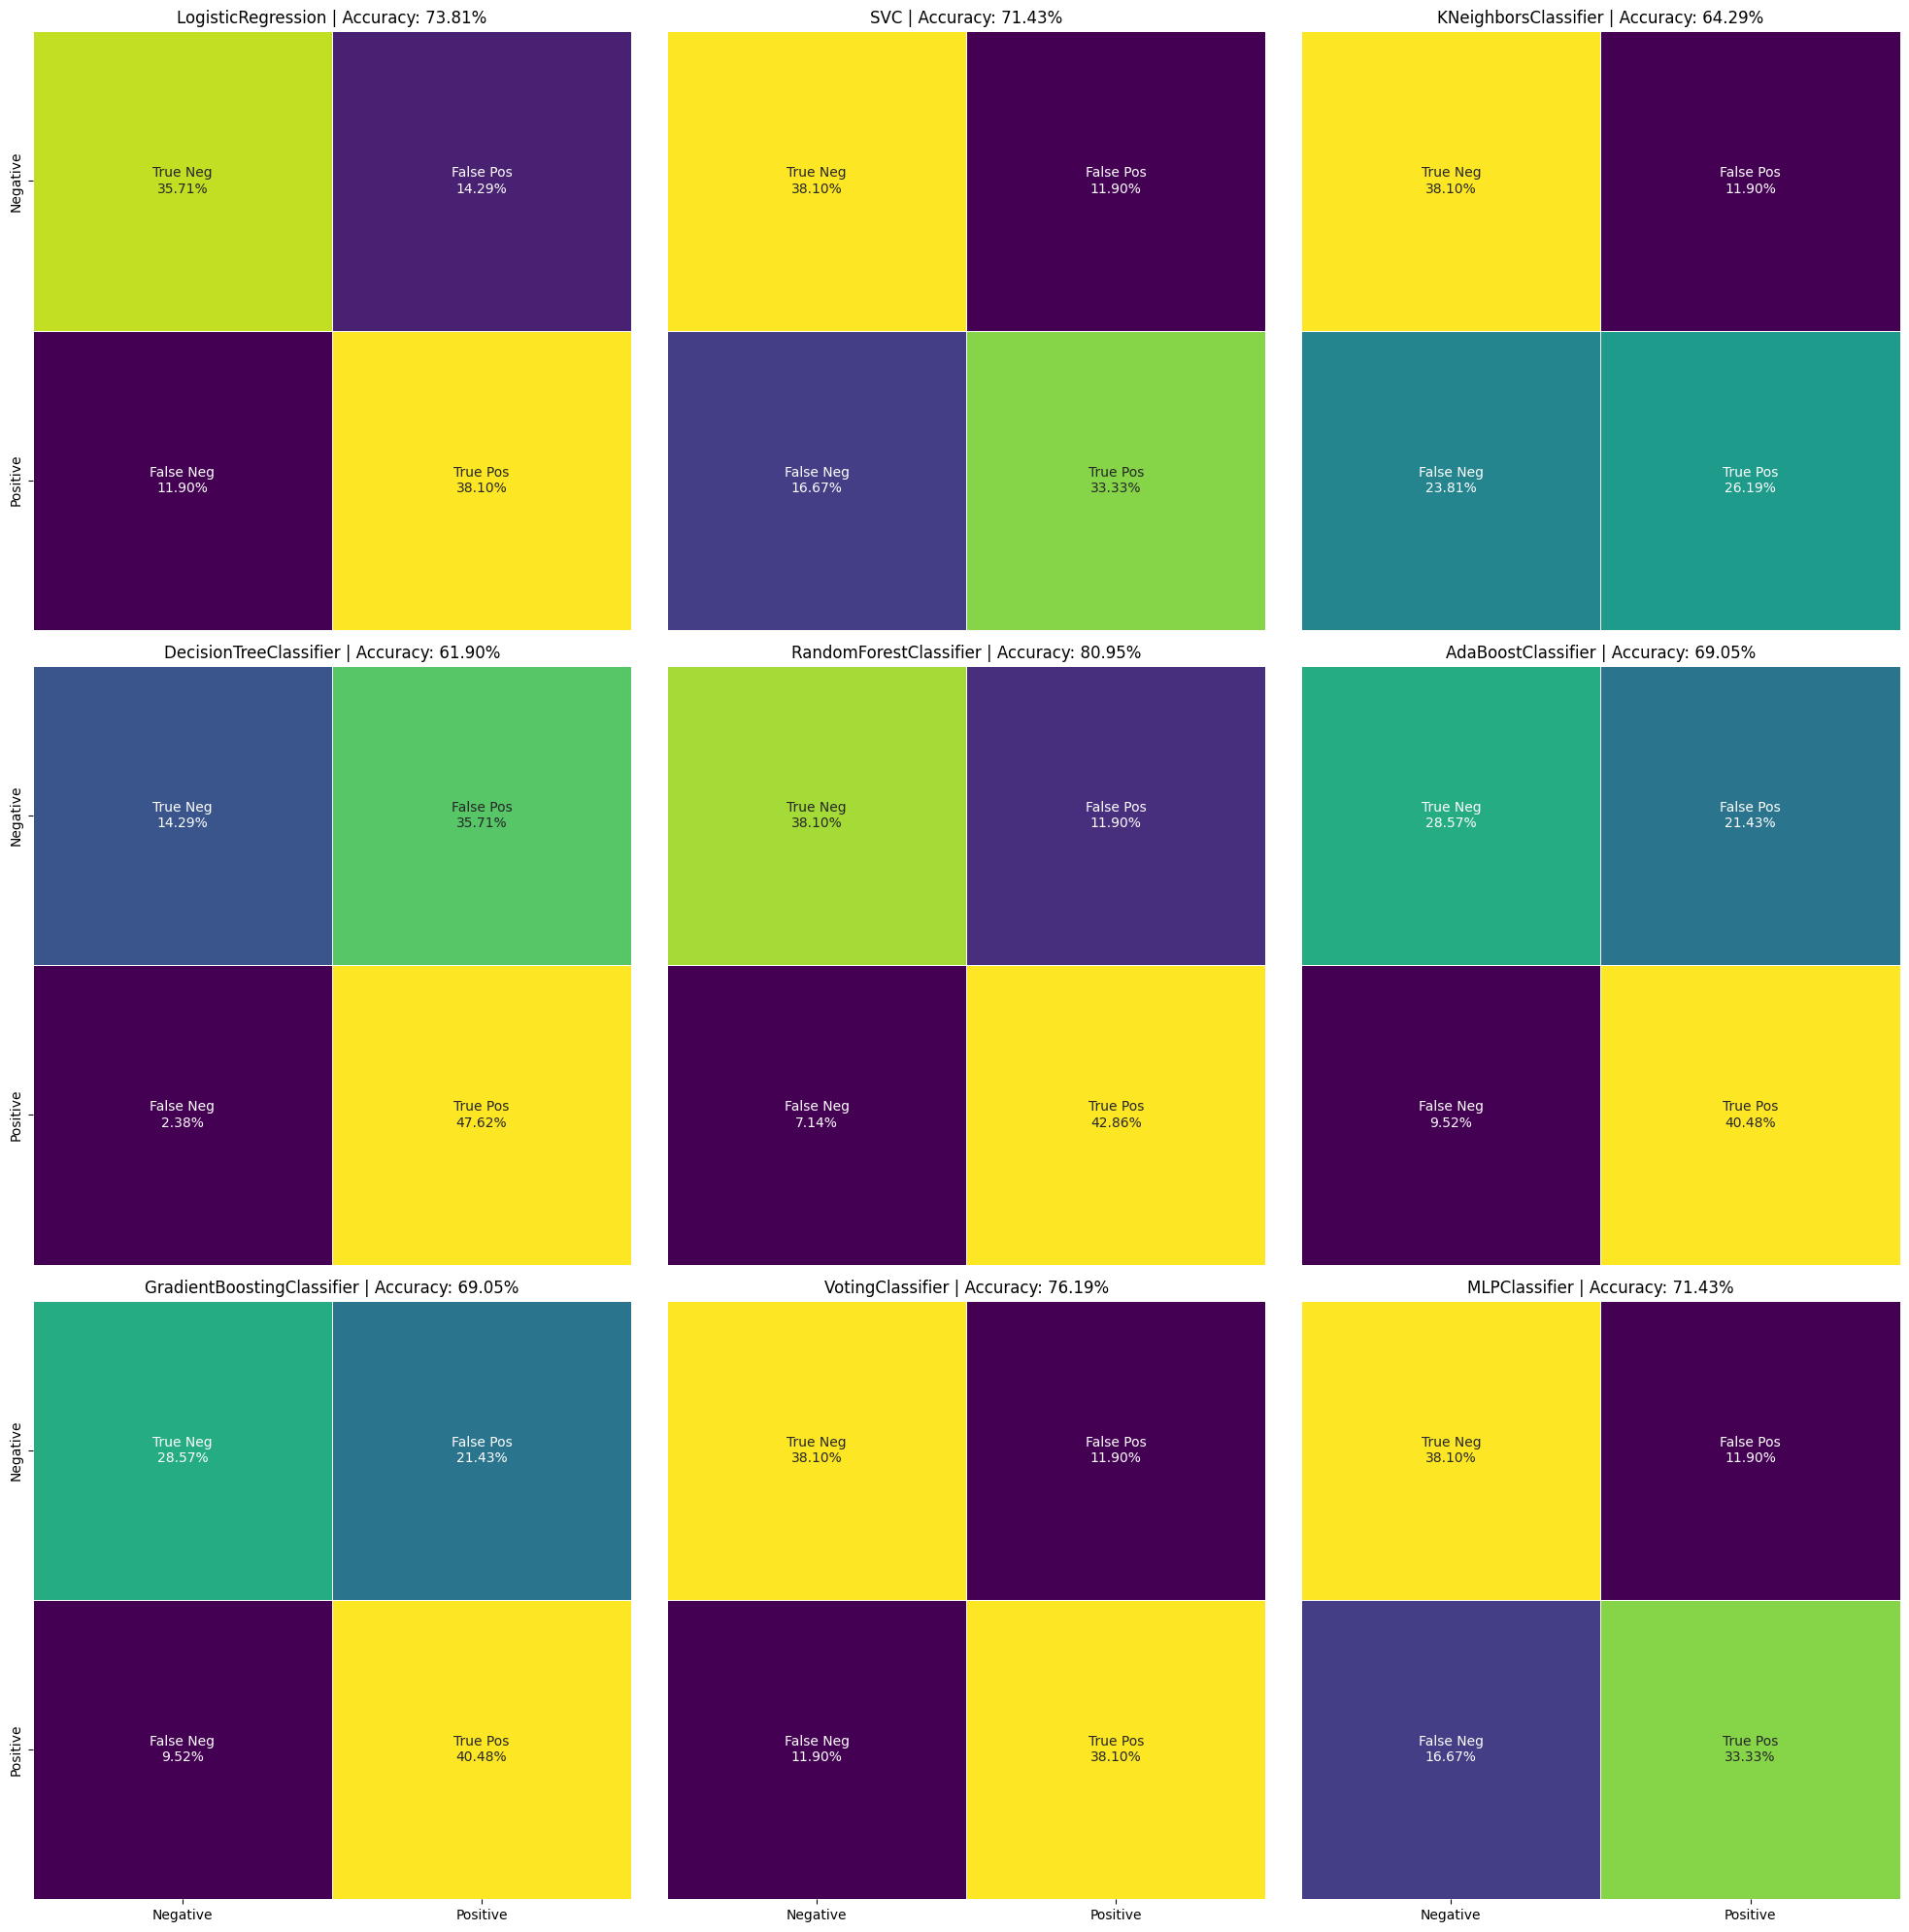

In [23]:
fig = plt.figure(figsize=(20, 20))
N_COLS = 3
N_ROWS = len(estimators) // N_COLS

results = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F1", "ROC AUC", "Time", "Memory"])
for i, (clf, tim, mem) in enumerate(tqdm(estimators, unit="clf")):
    name = clf.__class__.__name__

    # Predict
    y_pred = clf.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    ax = plt.subplot(N_ROWS, N_COLS, i + 1, aspect="equal")
    ax.grid(False)
    ax.set_title(f"{name} | Accuracy: {accuracy:.2%}")

    labels = ["Negative", "Positive"]
    sns.heatmap(
        cm,
        xticklabels=labels if i // N_COLS == N_ROWS - 1 else [],
        yticklabels=labels if i % N_COLS == 0 else [],
        annot=cm_annotations(cm),
        square=True,
        cbar=False,
        cmap="viridis",
        linewidths=0.5,
        fmt="",
        ax=ax,
    )

    # Save results
    results.loc[i] = [name, accuracy, precision, recall, f1, roc_auc, tim, mem // 1024]

plt.tight_layout()
plt.show()

In [24]:
# Sort the results by accuracy
results = results.sort_values("Accuracy", ascending=False).reset_index(drop=True)

# Save the results to CSV
output_results = results.copy()
output_results.columns = output_results.columns.str.lower().str.replace(" ", "_")
output_results = output_results.rename(columns={"time": "time_seconds", "memory": "memory_kb"})
output_results.to_csv(DATA_DIR / "proto_results.csv", index=False)

In [25]:
# Display the results
results.style.format(
    {
        "Accuracy": "{:.2%}",
        "Precision": "{:.2%}",
        "Recall": "{:.2%}",
        "F1": "{:.2%}",
        "ROC AUC": "{:.2%}",
        "Time": "{:.2f}s",
        "Memory": "{}KB",
    },
)

,Classifier,Accuracy,Precision,Recall,F1,ROC AUC,Time,Memory
0,RandomForestClassifier,80.95%,78.26%,85.71%,81.82%,80.95%,97.70s,504KB
1,VotingClassifier,76.19%,76.19%,76.19%,76.19%,76.19%,69.08s,1288KB
2,LogisticRegression,73.81%,72.73%,76.19%,74.42%,73.81%,0.96s,310KB
3,SVC,71.43%,73.68%,66.67%,70.00%,71.43%,0.56s,244KB
4,MLPClassifier,71.43%,73.68%,66.67%,70.00%,71.43%,20.38s,1208KB
5,AdaBoostClassifier,69.05%,65.38%,80.95%,72.34%,69.05%,93.89s,643KB
6,GradientBoostingClassifier,69.05%,65.38%,80.95%,72.34%,69.05%,46.88s,899KB
7,KNeighborsClassifier,64.29%,68.75%,52.38%,59.46%,64.29%,0.46s,293KB
8,DecisionTreeClassifier,61.90%,57.14%,95.24%,71.43%,61.90%,0.53s,324KB
